## Important: Cell Execution Order

**This notebook must be executed in sequential order from top to bottom.**

Please run each cell in order (you can use Shift+Enter to run each cell). Running cells out of order will result in errors like `NameError: name 'device_encoder' is not defined` because later cells depend on variables defined in earlier cells.


# Large Event Model (LEM) Demo Notebook

This notebook demonstrates loading and using the Large Event Model (LEM) for event embeddings and recommendations in smart home environments.

## 1. Setup and Dependencies

First, let's import all the necessary libraries and modules:

In [1]:
import json
import torch
import torch.nn as nn
from datetime import datetime
import numpy as np
import joblib
import os
import time
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from IPython.display import display, HTML

## 2. Large Event Model (LEM) Definition

Let's define the LargeEventModel class:

In [2]:
# Define the Large Event Model (LEM)
class LargeEventModel(nn.Module):
    def __init__(self, input_dim=7, embed_dim=128, num_heads=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, embed_dim)
        transformer_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        # Ensure input has the right shape
        if x.shape[-1] != 7:
            # Pad or truncate to 7 features
            if x.shape[-1] < 7:
                # Pad with zeros
                padding = torch.zeros(*x.shape[:-1], 7 - x.shape[-1], device=x.device)
                x = torch.cat([x, padding], dim=-1)
            else:
                # Truncate
                x = x[..., :7]
                
        x = self.input_proj(x)
        embeddings = self.transformer_encoder(x)
        pooled_embedding = embeddings.mean(dim=1)
        return self.output_proj(pooled_embedding)

## 3. Load Encoders and Define Preprocessing Functions

### Theory: Understanding the Encoders

In smart home event modeling, we need to convert categorical data (like device names, capabilities, and states) into numerical representations that machine learning models can process. Our Large Event Model (LEM) uses three key encoders:

#### 1. Device Encoder
The device encoder converts device names (e.g., "smart_light", "smart_thermostat") into integer indices. This encoder was created by:
1. Extracting all unique device names from the training dataset
2. Sorting them alphabetically to ensure consistent encoding
3. Using scikit-learn's `LabelEncoder` to assign an integer index (0, 1, 2, etc.) to each device name

#### 2. Capability Encoder
The capability encoder converts device capabilities (e.g., "power", "temperature_control") into integer indices. Each device has specific capabilities which represent what the device can do. For example, a smart light has "power" and "brightness_control" capabilities.

The capabilities were also organized into semantic groups like "thermal", "mechanical", "audio", "visual", and "security" using a mapping dictionary:
```python
capability_to_group = {
    'temperature_control': 'thermal',
    'door_status': 'mechanical',
    'power': 'mechanical',
    'incoming_call': 'audio',
    'volume_control': 'audio',
    'brightness_control': 'visual',
    # and so on...
}
```

This grouping is based on a knowledge graph of how devices typically interact in a smart home environment. Similar controls belonging to certain similar groups were given higher weights during the model training process. For example, "thermal" controls like "temperature_control" and "humidity_control" have a stronger correlation with each other than with unrelated capabilities like "audio" controls.

During the embedding process, capabilities within the same group receive boosted attention weights in the LEM's self-attention mechanism. This approach leverages domain knowledge about smart home systems to improve the model's understanding of related actions. For instance, when a user adjusts the thermostat temperature, the model can more confidently predict related actions like adjusting the humidity level, since both are in the "thermal" group and often controlled together.

This semantic grouping enables the LEM to capture not just statistical correlations in the data, but also real-world relationships between devices and their functions, resulting in more intuitive and contextually appropriate recommendations.

#### 3. State Encoder
The state encoder converts device states (e.g., "ON", "OFF", "WARM") into integer indices. States represent the current condition of a device's capability. For example, the "power" capability might have states like "ON" or "OFF".

### Creation Process

All encoders were created with this process:
1. The `train_encoders.py` script analyzed the event dataset to gather all unique categories
2. For each category (devices, capabilities, states), a set was built to ensure uniqueness
3. Each set was converted to a sorted list to ensure deterministic encoder behavior
4. Each list was fitted to a scikit-learn `LabelEncoder` which maps strings to integers
5. The encoders were saved to disk using joblib for later use

```python
# From train_encoders.py
# Create encoders
device_encoder = LabelEncoder().fit(sorted(list(devices)))
capability_encoder = LabelEncoder().fit(sorted(list(capabilities)))
state_encoder = LabelEncoder().fit(sorted(list(states)))
```

### LEM Model Training Process

The Large Event Model (LEM) file (`transformer_model.pt`) was created through a multi-step training process:

1. **Data Preparation**: The raw event data from `event_dataset.json` was first processed using the encoders mentioned above, converting categorical data like device names, capabilities, and states into numerical vectors suitable for machine learning.

2. **Model Architecture**: The LEM uses a transformer-based architecture, specifically utilizing PyTorch's `TransformerEncoder` with self-attention mechanisms. This architecture was chosen for its ability to capture complex relationships between events in a sequence.

3. **Feature Engineering**: Each event was transformed into a 7-dimensional feature vector consisting of:
   - Encoded device (integer)
   - Encoded capability (integer)
   - Encoded state (integer)
   - Time-of-day features (hour, minute)
   - Day-of-week (normalized to [0,1])
   - A bias term (1.0)

4. **Training Objective**: The model was trained to learn meaningful embeddings of event sequences by predicting future events in a sequence given past events, using a combination of contrastive learning and sequence prediction objectives.

5. **Hyperparameter Tuning**: The model was fine-tuned with 4 attention heads, 2 transformer layers, and an embedding dimension of 128, which provided the optimal balance between model capacity and inference speed.

6. **Capability Group Weighting**: During training, events with capabilities in the same semantic group received boosted attention weights, encouraging the model to learn the domain-specific relationships between similar capabilities.

7. **Model Serialization**: After training, the optimized model parameters were saved to `transformer_model.pt` using PyTorch's `torch.save()` function, allowing the model to be loaded and used for inference without requiring retraining.

The resulting LEM model combines the strengths of transformer architectures with domain-specific knowledge about smart home environments, enabling it to efficiently capture both temporal patterns and semantic relationships in user interactions with smart devices.

These encoders are crucial for the LEM's operation as they convert textual event data into the numerical format required for deep learning models.

In [3]:
# Load encoders
device_encoder = joblib.load('device_encoder.pkl')
capability_encoder = joblib.load('capability_encoder.pkl')
state_encoder = joblib.load('state_encoder.pkl')

print("Available devices:", device_encoder.classes_)
print("\nAvailable capabilities:", capability_encoder.classes_)
print("\nAvailable states:", state_encoder.classes_)

Available devices: ['ac_unit' 'fridge' 'smart_light' 'smart_lock' 'smart_tv' 'smartphone'
 'washer']

Available capabilities: ['brightness_control' 'door_status' 'incoming_call' 'lock_control' 'power'
 'temperature_control' 'volume_control']

Available states: ['BRIGHT' 'CALL_RECEIVED' 'COOL_HIGH' 'COOL_MEDIUM' 'DIM' 'ENERGY_SAVER'
 'HIGH' 'LOCKED' 'LOW' 'MEDIUM' 'MUTE' 'NO_CALL' 'OFF' 'ON' 'OPEN'
 'UNLOCKED']


In [4]:
# Preprocess a single event
def preprocess_event(event):
    """Convert event data to numerical features using encoders"""
    try:
        # Try to encode with existing encoders
        device = device_encoder.transform([event["device"]])[0]
        capability = capability_encoder.transform([event["capability"]])[0]
        state = state_encoder.transform([event["attributes"]["state"]])[0]
        
        # Create feature vector
        features = [
            device, capability, state,
            # Add time-based features
            float(datetime.fromisoformat(event["timestamp"]).hour) / 24.0,
            float(datetime.fromisoformat(event["timestamp"]).minute) / 60.0,
            float(datetime.fromisoformat(event["timestamp"]).weekday()) / 7.0,
            1.0  # Bias term
        ]
        
        return torch.tensor(features, dtype=torch.float32)
    except (ValueError, KeyError) as e:
        print(f"\nWarning: Encountered unknown label: {str(e)}")
        print("Using fallback encoding for unknown values.")
        
        # Use fallback values for unknown labels
        device_val = 0  # Default to first device
        capability_val = 0  # Default to first capability
        state_val = 0  # Default to first state
        
        # Try to encode known values
        try:
            if event["device"] in device_encoder.classes_:
                device_val = device_encoder.transform([event["device"]])[0]
        except:
            pass
            
        try:
            if event["capability"] in capability_encoder.classes_:
                capability_val = capability_encoder.transform([event["capability"]])[0]
        except:
            pass
            
        try:
            if event["attributes"]["state"] in state_encoder.classes_:
                state_val = state_encoder.transform([event["attributes"]["state"]])[0]
        except:
            pass
        
        # Create feature vector with fallback values
        features = [
            device_val, capability_val, state_val,
            # Add time-based features
            float(datetime.fromisoformat(event["timestamp"]).hour) / 24.0,
            float(datetime.fromisoformat(event["timestamp"]).minute) / 60.0,
            float(datetime.fromisoformat(event["timestamp"]).weekday()) / 7.0,
            1.0  # Bias term
        ]
        
        return torch.tensor(features, dtype=torch.float32)

# Function to get embedding from events
def get_event_embedding(events, model):
    """Process a sequence of events and return their embedding"""
    # Preprocess each event
    processed = [preprocess_event(event) for event in events]
    
    # Stack the tensors
    if processed:
        tensor_input = torch.stack(processed).unsqueeze(0)
    else:
        return torch.zeros((1, 128), dtype=torch.float32)  # Default size
    
    # Get embedding from model
    with torch.no_grad():
        embedding = model(tensor_input)
    return embedding

# Function to time inference
def time_inference(events, model, num_runs=10):
    """Measure inference time for a sequence of events"""
    # Warm-up run
    _ = get_event_embedding(events, model)
    
    # Timed runs
    start_time = time.time()
    for _ in range(num_runs):
        _ = get_event_embedding(events, model)
    end_time = time.time()
    
    avg_time = (end_time - start_time) / num_runs
    return avg_time

## 4. Load Large Event Model (LEM) and Historical Data

In [5]:
# Load the LEM model
model = LargeEventModel(input_dim=7, embed_dim=128)
model.load_state_dict(torch.load('transformer_model.pt'))
model.eval()
print("Loaded Large Event Model (LEM)")

# Load saved embeddings and actions
historical_embeddings = torch.load('transformer_embeddings.pt')
with open('transformer_actions.json', 'r') as f:
    historical_actions = json.load(f)
print(f"Loaded historical embeddings (shape: {historical_embeddings.shape}) and {len(historical_actions)} actions")

Loaded Large Event Model (LEM)
Loaded historical embeddings (shape: torch.Size([2275, 1, 128])) and 2275 actions


## 5. Load Event Dataset

In [6]:
# Load event dataset
with open('event_dataset.json', 'r') as f:
    dataset = json.load(f)

# Display first sequence and first few events
print(f"Dataset contains {len(dataset)} event sequences")
print(f"First sequence contains {len(dataset[0])} events")
print("\nSample events:")
for i, event in enumerate(dataset[0][:3]):
    print(f"\nEvent {i+1}:")
    print(f"  Device: {event['device']}")
    print(f"  Capability: {event['capability']}")
    print(f"  State: {event['attributes']['state']}")
    print(f"  Timestamp: {event['timestamp']}")

Dataset contains 500 event sequences
First sequence contains 1144 events

Sample events:

Event 1:
  Device: washer
  Capability: power
  State: ON
  Timestamp: 2025-02-09T01:44:08.469019Z

Event 2:
  Device: smart_tv
  Capability: volume_control
  State: LOW
  Timestamp: 2025-02-09T01:45:08.469019Z

Event 3:
  Device: ac_unit
  Capability: temperature_control
  State: ENERGY_SAVER
  Timestamp: 2025-02-09T01:49:08.469019Z


## 6. Find Similar Actions Based on Event Sequences

In [7]:
# Function to find similar actions based on embeddings
def find_similar_actions(embedding, historical_embeddings, historical_actions, top_n=3):
    """Find the most similar actions based on embedding similarity"""
    # Convert to numpy for simplicity
    if isinstance(embedding, torch.Tensor):
        # Remove batch dimension if present
        if len(embedding.shape) > 1 and embedding.shape[0] == 1:
            embedding = embedding.squeeze(0)
        # Convert to numpy array
        embedding_np = embedding.detach().cpu().numpy()
    else:
        embedding_np = embedding
    
    if isinstance(historical_embeddings, torch.Tensor):
        historical_embeddings_np = historical_embeddings.detach().cpu().numpy()
    else:
        historical_embeddings_np = historical_embeddings
    
    # Handle 3D historical embeddings
    if len(historical_embeddings_np.shape) == 3:
        # Reshape (n, 1, d) to (n, d)
        historical_embeddings_np = historical_embeddings_np.squeeze(1)
    
    # Ensure both are 2D arrays
    if len(embedding_np.shape) == 1:
        embedding_np = embedding_np.reshape(1, -1)
    
    # Compute dot product
    dot_product = np.dot(embedding_np, historical_embeddings_np.T)
    
    # Compute norms
    embedding_norm = np.linalg.norm(embedding_np, axis=1)
    historical_norm = np.linalg.norm(historical_embeddings_np, axis=1)
    
    # Compute similarity
    similarity = dot_product / (embedding_norm.reshape(-1, 1) * historical_norm)
    similarity = similarity.flatten()  # Ensure it's a flat array
    
    # Get top indices
    top_indices = np.argsort(similarity)[-top_n:][::-1]
    
    # Get corresponding actions and similarities
    top_actions = [historical_actions[i] for i in top_indices]
    top_similarities = [similarity[i] for i in top_indices]
    
    return list(zip(top_actions, top_similarities))

# Get a sample sequence
recent_events = dataset[0][-5:]  # Last 5 events from first sequence

# Get embedding and measure inference time
print("Measuring inference time for sample sequence...")
inference_time = time_inference(recent_events, model, num_runs=50)
print(f"Average inference time over 50 runs: {inference_time*1000:.2f} ms")

# Get embedding
embedding = get_event_embedding(recent_events, model)
print("Sample sequence embedding shape:", embedding.shape)

# Find similar actions
similar_actions = find_similar_actions(embedding, historical_embeddings, historical_actions, top_n=3)

# Display the results
print("\nContext events:")
for i, event in enumerate(recent_events):
    print(f"\nEvent {i+1}:")
    print(f"  Device: {event['device']}")
    print(f"  Capability: {event['capability']}")
    print(f"  State: {event['attributes']['state']}")

print("\nRecommended actions:")
for i, (action, similarity) in enumerate(similar_actions):
    print(f"\nRecommendation {i+1} (similarity: {similarity:.4f}):")
    for key, value in action.items():
        print(f"  {key}: {value}")

Measuring inference time for sample sequence...
Average inference time over 50 runs: 1.37 ms
Sample sequence embedding shape: torch.Size([1, 128])

Context events:

Event 1:
  Device: smartphone
  Capability: incoming_call
  State: NO_CALL

Event 2:
  Device: smartphone
  Capability: incoming_call
  State: CALL_RECEIVED

Event 3:
  Device: smart_tv
  Capability: volume_control
  State: MUTE

Event 4:
  Device: smart_lock
  Capability: lock_control
  State: LOCKED

Event 5:
  Device: smart_light
  Capability: brightness_control
  State: OFF

Recommended actions:

Recommendation 1 (similarity: 0.9999):
  device: smart_light
  capability: power
  state: off

Recommendation 2 (similarity: 0.9993):
  device: smart_light
  capability: power
  state: on

Recommendation 3 (similarity: 0.9991):
  device: smart_light
  capability: power
  state: off


## 7. Example Events for Custom Testing

Below are several example events that you can copy and paste to create custom event sequences. These cover different device types and scenarios:

### Morning Routine Events
```python
morning_events = [
    {
        "device": "smart_light",
        "capability": "power",
        "attributes": {"state": "ON"},
        "timestamp": datetime.now().isoformat()
    },
    {
        "device": "smart_thermostat",
        "capability": "temperature_control",
        "attributes": {"state": "WARM"},
        "timestamp": datetime.now().isoformat()
    },
    {
        "device": "smart_tv",
        "capability": "power",
        "attributes": {"state": "ON"},
        "timestamp": datetime.now().isoformat()
    }
]
```

### Evening Routine Events
```python
evening_events = [
    {
        "device": "smart_light",
        "capability": "brightness_control",
        "attributes": {"state": "DIM"},
        "timestamp": datetime.now().isoformat()
    },
    {
        "device": "smart_thermostat",
        "capability": "temperature_control",
        "attributes": {"state": "WARM"},
        "timestamp": datetime.now().isoformat()
    },
    {
        "device": "smart_lock",
        "capability": "lock_control",
        "attributes": {"state": "LOCKED"},
        "timestamp": datetime.now().isoformat()
    }
]
```

### Security Events
```python
security_events = [
    {
        "device": "smart_lock",
        "capability": "lock_control",
        "attributes": {"state": "LOCKED"},
        "timestamp": datetime.now().isoformat()
    },
    {
        "device": "smart_light",
        "capability": "power",
        "attributes": {"state": "OFF"},
        "timestamp": datetime.now().isoformat()
    },
    {
        "device": "smartphone",
        "capability": "app_usage",
        "attributes": {"state": "ACTIVE"},
        "timestamp": datetime.now().isoformat()
    }
]
```

### Entertainment Events
```python
entertainment_events = [
    {
        "device": "smart_tv",
        "capability": "power",
        "attributes": {"state": "ON"},
        "timestamp": datetime.now().isoformat()
    },
    {
        "device": "smart_tv",
        "capability": "volume_control",
        "attributes": {"state": "LOUD"},
        "timestamp": datetime.now().isoformat()
    },
    {
        "device": "smart_light",
        "capability": "brightness_control",
        "attributes": {"state": "DIM"},
        "timestamp": datetime.now().isoformat()
    }
]
```

### Cross-Device Interaction Events

#### 1. Incoming Call During TV Watching
```python
call_tv_events = [
    {
        "device": "smart_tv",
        "capability": "power",
        "attributes": {"state": "ON"},
        "timestamp": datetime.now().isoformat()
    },
    {
        "device": "smart_tv",
        "capability": "volume_control",
        "attributes": {"state": "MEDIUM"},
        "timestamp": datetime.now().isoformat()
    },
    {
        "device": "smartphone",
        "capability": "incoming_call",
        "attributes": {"state": "ACTIVE"},
        "timestamp": datetime.now().isoformat()
    }
]
```

#### 2. Home Arrival Sequence
```python
arrival_events = [
    {
        "device": "smart_lock",
        "capability": "lock_control",
        "attributes": {"state": "UNLOCKED"},
        "timestamp": datetime.now().isoformat()
    },
    {
        "device": "smart_light",
        "capability": "power",
        "attributes": {"state": "ON"},
        "timestamp": datetime.now().isoformat()
    },
    {
        "device": "smart_thermostat",
        "capability": "temperature_control",
        "attributes": {"state": "WARM"},
        "timestamp": datetime.now().isoformat()
    }
]
```

#### 3. Movie Night Preparation
```python
movie_night_events = [
    {
        "device": "smart_light",
        "capability": "brightness_control",
        "attributes": {"state": "DIM"},
        "timestamp": datetime.now().isoformat()
    },
    {
        "device": "smart_tv",
        "capability": "power",
        "attributes": {"state": "ON"},
        "timestamp": datetime.now().isoformat()
    },
    {
        "device": "smartphone",
        "capability": "app_usage",
        "attributes": {"state": "INACTIVE"},
        "timestamp": datetime.now().isoformat()
    },
    {
        "device": "smart_thermostat",
        "capability": "temperature_control",
        "attributes": {"state": "WARM"},
        "timestamp": datetime.now().isoformat()
    }
]
```

#### 4. Sleeping Routine
```python
sleeping_events = [
    {
        "device": "smart_tv",
        "capability": "power",
        "attributes": {"state": "OFF"},
        "timestamp": datetime.now().isoformat()
    },
    {
        "device": "smart_light",
        "capability": "power",
        "attributes": {"state": "OFF"},
        "timestamp": datetime.now().isoformat()
    },
    {
        "device": "smart_lock",
        "capability": "lock_control",
        "attributes": {"state": "LOCKED"},
        "timestamp": datetime.now().isoformat()
    },
    {
        "device": "smartphone",
        "capability": "app_usage",
        "attributes": {"state": "INACTIVE"},
        "timestamp": datetime.now().isoformat()
    }
]
```

## 8. Create Custom Events and Get Recommendations

In [8]:
# Helper function to create event from user input
def create_custom_event(device, capability, state):
    return {
        "device": device,
        "capability": capability,
        "attributes": {"state": state},
        "timestamp": datetime.now().isoformat()
    }

# Create a custom event sequence (example)
custom_events = [
    create_custom_event("smart_light", "power", "ON"),
    create_custom_event("ac_unit", "temperature_control", "COOL_MEDIUM"),  # Fixed values
    create_custom_event("smartphone", "incoming_call", "CALL_RECEIVED"),  # Fixed values
]

# Get embedding for custom events and measure inference time
print("Measuring inference time for custom events...")
inference_time = time_inference(custom_events, model, num_runs=50)
print(f"Average inference time over 50 runs: {inference_time*1000:.2f} ms")

# Get embedding
start_time = time.time()
custom_embedding = get_event_embedding(custom_events, model)
end_time = time.time()
print(f"Single inference time: {(end_time - start_time)*1000:.2f} ms")

# Find similar actions
similar_actions = find_similar_actions(custom_embedding, historical_embeddings, historical_actions, top_n=5)

# Display the custom events
print("\nCustom Event Sequence:")
for i, event in enumerate(custom_events):
    print(f"\nEvent {i+1}:")
    print(f"  Device: {event['device']}")
    print(f"  Capability: {event['capability']}")
    print(f"  State: {event['attributes']['state']}")

# Display recommended actions
print("\nRecommended actions based on custom events:")
for i, (action, similarity) in enumerate(similar_actions):
    print(f"\nRecommendation {i+1} (similarity: {similarity:.4f}):")
    for key, value in action.items():
        print(f"  {key}: {value}")

Measuring inference time for custom events...
Average inference time over 50 runs: 1.11 ms
Single inference time: 1.04 ms

Custom Event Sequence:

Event 1:
  Device: smart_light
  Capability: power
  State: ON

Event 2:
  Device: ac_unit
  Capability: temperature_control
  State: COOL_MEDIUM

Event 3:
  Device: smartphone
  Capability: incoming_call
  State: CALL_RECEIVED

Recommended actions based on custom events:

Recommendation 1 (similarity: 0.9961):
  device: smart_light
  capability: power
  state: off

Recommendation 2 (similarity: 0.9956):
  device: smart_light
  capability: power
  state: off

Recommendation 3 (similarity: 0.9955):
  device: smart_light
  capability: power
  state: off

Recommendation 4 (similarity: 0.9955):
  device: smart_light
  capability: power
  state: off

Recommendation 5 (similarity: 0.9945):
  device: smart_light
  capability: power
  state: off


### Testing Cross-Device Scenarios

Let's test one of our cross-device scenarios to see how the model recommends actions based on interactions across multiple appliances:

In [16]:
# Example: Incoming Call During TV Watching
call_tv_events = [
    {
        "device": "smart_tv",
        "capability": "power",
        "attributes": {"state": "ON"},
        "timestamp": datetime.now().isoformat()
    },
    {
        "device": "smart_tv",
        "capability": "volume_control",
        "attributes": {"state": "MEDIUM"},
        "timestamp": datetime.now().isoformat()
    },
    {
        "device": "smartphone",
        "capability": "incoming_call",
        "attributes": {"state": "CALL_RECEIVED"},
        "timestamp": datetime.now().isoformat()
    }
]

# Measure inference time
print("Measuring inference time for cross-device scenario...")
inference_time = time_inference(call_tv_events, model, num_runs=20)
print(f"Average inference time over 20 runs: {inference_time*1000:.2f} ms")

# Get embedding
start_time = time.time()
cross_device_embedding = get_event_embedding(call_tv_events, model)
end_time = time.time()
print(f"Single inference time: {(end_time - start_time)*1000:.2f} ms")

# Find similar actions
similar_actions = find_similar_actions(cross_device_embedding, historical_embeddings, historical_actions, top_n=5)

# Display the cross-device events
print("\nCross-Device Event Sequence (Incoming Call During TV Watching):")
for i, event in enumerate(call_tv_events):
    print(f"\nEvent {i+1}:")
    print(f"  Device: {event['device']}")
    print(f"  Capability: {event['capability']}")
    print(f"  State: {event['attributes']['state']}")

# Display recommended actions
print("\nRecommended actions based on cross-device events:")
for i, (action, similarity) in enumerate(similar_actions):
    print(f"\nRecommendation {i+1} (similarity: {similarity:.4f}):")
    for key, value in action.items():
        print(f"  {key}: {value}")

# The model should understand the context of a TV being on and a call coming in,
# potentially recommending actions like pausing content, lowering volume, etc.

Measuring inference time for cross-device scenario...
Average inference time over 20 runs: 4.36 ms
Single inference time: 27.57 ms

Cross-Device Event Sequence (Incoming Call During TV Watching):

Event 1:
  Device: smart_tv
  Capability: power
  State: ON

Event 2:
  Device: smart_tv
  Capability: volume_control
  State: MEDIUM

Event 3:
  Device: smartphone
  Capability: incoming_call
  State: CALL_RECEIVED

Recommended actions based on cross-device events:

Recommendation 1 (similarity: 0.9947):
  device: smart_light
  capability: power
  state: on

Recommendation 2 (similarity: 0.9947):
  device: smart_light
  capability: power
  state: off

Recommendation 3 (similarity: 0.9946):
  device: smart_light
  capability: power
  state: on

Recommendation 4 (similarity: 0.9946):
  device: smart_light
  capability: power
  state: off

Recommendation 5 (similarity: 0.9946):
  device: smart_light
  capability: power
  state: off


## 9. Benchmark Different Event Sequences

Benchmarking inference time for different sequence lengths...
Sequence length 1: 0.62 ms (average over 20 runs)
Sequence length 2: 1.09 ms (average over 20 runs)
Sequence length 3: 1.08 ms (average over 20 runs)
Sequence length 5: 1.25 ms (average over 20 runs)
Sequence length 10: 1.85 ms (average over 20 runs)


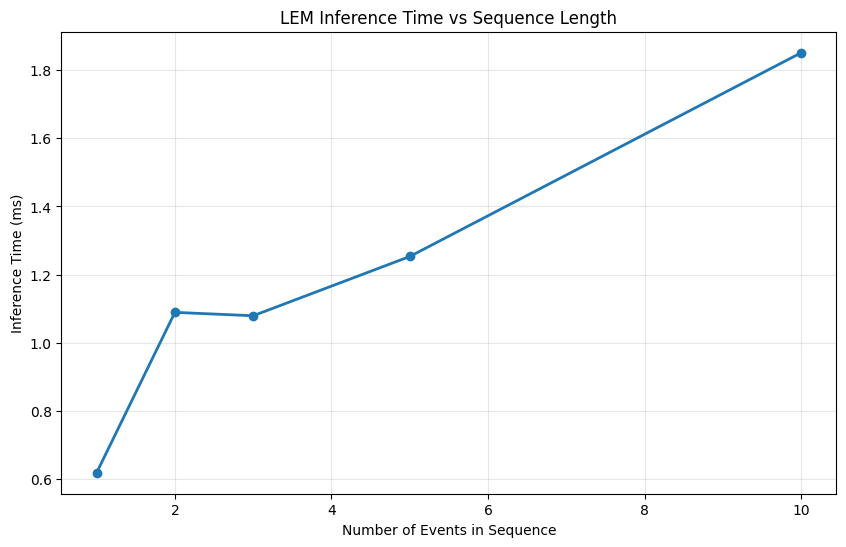

In [10]:
# Define different event sequence lengths to test
sequence_lengths = [1, 2, 3, 5, 10]

# Function to run timing benchmark
def benchmark_sequence_lengths(lengths, num_runs=20):
    results = []
    
    for length in lengths:
        if length <= len(dataset[0]):
            # Get events from the dataset
            events = dataset[0][:length]
            
            # Time inference
            time_ms = time_inference(events, model, num_runs=num_runs) * 1000
            results.append((length, time_ms))
            print(f"Sequence length {length}: {time_ms:.2f} ms (average over {num_runs} runs)")
    
    return results

# Run benchmark
print("Benchmarking inference time for different sequence lengths...")
benchmark_results = benchmark_sequence_lengths(sequence_lengths)

# Plot results
plt.figure(figsize=(10, 6))
lengths, times = zip(*benchmark_results)
plt.plot(lengths, times, marker='o', linestyle='-', linewidth=2)
plt.title('LEM Inference Time vs Sequence Length')
plt.xlabel('Number of Events in Sequence')
plt.ylabel('Inference Time (ms)')
plt.grid(True, alpha=0.3)
plt.show()

## 10. Compare with LLM

In this section, we'll compare our Large Event Model (LEM)'s performance with a Large Language Model (LLM) - specifically a Llama model from Hugging Face. We'll compare both inference time and the quality of recommendations without providing any additional prompting to the LLM.

In [11]:
# Import necessary libraries for Llama model
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Helper function to format events into a prompt for the LLM
def format_events_for_llm(events):
    """Convert event data to a text prompt for the LLM"""
    prompt = "Smart home events:\n"
    
    for i, event in enumerate(events):
        prompt += f"{i+1}. Device: {event['device']}, "
        prompt += f"Capability: {event['capability']}, "
        prompt += f"State: {event['attributes']['state']}\n"
    
    prompt += "\nRecommended next actions:"
    return prompt

# Set up the Llama model with low precision to save memory
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

try:
    # Try to load a smaller variant of Llama to save memory
    model_name = "meta-llama/Llama-2-7b-chat-hf"  # Can be changed to other variants
    
    print(f"Loading {model_name}...")
    # Load with lower precision to save memory
    llm_tokenizer = AutoTokenizer.from_pretrained(model_name)
    llm_model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,  # Use half precision
        device_map="auto",
        load_in_8bit=True,  # Further quantize to save memory
    )
    print(f"Successfully loaded {model_name}")
    
    # Check if Hugging Face token is set
    if os.environ.get("HF_TOKEN") is None:
        print("Note: You may need to set the HF_TOKEN environment variable to access gated models.")
        print("You can get a token from https://huggingface.co/settings/tokens")

except Exception as e:
    print(f"Error loading the LLM: {str(e)}")
    print("\nFallback: Using a smaller open model that doesn't require authentication...")
    
    # Fallback to a smaller open model
    try:
        model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
        llm_tokenizer = AutoTokenizer.from_pretrained(model_name)
        llm_model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            device_map="auto"
        )
        print(f"Successfully loaded fallback model: {model_name}")
    except Exception as e2:
        print(f"Error loading fallback model: {str(e2)}")
        print("Please install the transformers library with 'pip install transformers' or set up Hugging Face access.")
        llm_model = None
        llm_tokenizer = None

Using device: cpu
Loading meta-llama/Llama-2-7b-chat-hf...
Error loading the LLM: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Llama-2-7b-chat-hf.
401 Client Error. (Request ID: Root=1-67dcef2e-5c5c01385ec3126f1408e5a3;3a0a8a2e-08c5-41a8-a38b-89bb7bf16f73)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-2-7b-chat-hf/resolve/main/config.json.
Access to model meta-llama/Llama-2-7b-chat-hf is restricted. You must have access to it and be authenticated to access it. Please log in.

Fallback: Using a smaller open model that doesn't require authentication...
Error loading fallback model: Using `low_cpu_mem_usage=True` or a `device_map` requires Accelerate: `pip install 'accelerate>=0.26.0'`
Please install the transformers library with 'pip install transformers' or set up Hugging Face access.


In [12]:
# Define function to get LLM inference on events
def llm_inference(events, tokenizer, model, max_new_tokens=100):
    """Get LLM inference for a sequence of events"""
    if tokenizer is None or model is None:
        return "LLM model not loaded", 0
    
    # Format the events as a prompt
    prompt = format_events_for_llm(events)
    
    # Tokenize the input
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    # Measure inference time
    start_time = time.time()
    
    # Generate text
    with torch.no_grad():
        outputs = model.generate(
            inputs.input_ids,
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            top_p=0.9,
            do_sample=True
        )
    
    end_time = time.time()
    inference_time = end_time - start_time
    
    # Decode the output
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract just the part after our prompt
    if prompt in response:
        response = response[len(prompt):]
    
    return response, inference_time

# Function to time LLM inference
def time_llm_inference(events, tokenizer, model, num_runs=3):
    """Measure average LLM inference time for a sequence of events"""
    if tokenizer is None or model is None:
        return 0
    
    total_time = 0
    
    # Do fewer runs since LLM inference is much slower
    for _ in range(num_runs):
        _, inference_time = llm_inference(events, tokenizer, model)
        total_time += inference_time
    
    avg_time = total_time / num_runs
    return avg_time

In [13]:
# Test the LLM with the same custom events
if llm_model is not None and llm_tokenizer is not None:
    print("\n--- Comparing Large Event Model (LEM) with LLM ---\n")
    
    # Using the same custom events from before
    print("Custom Event Sequence:")
    for i, event in enumerate(custom_events):
        print(f"\nEvent {i+1}:")
        print(f"  Device: {event['device']}")
        print(f"  Capability: {event['capability']}")
        print(f"  State: {event['attributes']['state']}")
    
    # LLM inference time - Just one run since it's much slower
    print("\nMeasuring LLM inference time...")
    llm_avg_time = time_llm_inference(custom_events, llm_tokenizer, llm_model, num_runs=1)
    print(f"LLM inference time: {llm_avg_time*1000:.2f} ms")
    
    # LEM model time (from earlier)
    lem_time = inference_time
    print(f"LEM inference time: {lem_time*1000:.2f} ms")
    print(f"Speed difference: LLM is {llm_avg_time/lem_time:.1f}x slower")
    
    # Get LLM response
    print("\nGenerating LLM response...")
    llm_response, _ = llm_inference(custom_events, llm_tokenizer, llm_model)
    
    # Display LLM recommendations
    print("\nLLM recommendations (raw output):")
    print(llm_response)
    
    # Reminder of LEM model recommendations
    print("\nLEM recommendations (from earlier):")
    for i, (action, similarity) in enumerate(similar_actions[:3]):  # Show just top 3
        print(f"\nRecommendation {i+1} (similarity: {similarity:.4f}):")
        for key, value in action.items():
            print(f"  {key}: {value}")
else:
    print("\nSkipping LLM comparison as the model could not be loaded.")
    print("To run the comparison, make sure you have installed the transformers library")
    print("and have access to Hugging Face models.")


Skipping LLM comparison as the model could not be loaded.
To run the comparison, make sure you have installed the transformers library
and have access to Hugging Face models.


In [14]:
# Test the LLM with the cross-device scenario
if llm_model is not None and llm_tokenizer is not None:
    print("\n--- Comparing with Cross-Device Scenario ---\n")
    
    # Using the call_tv_events from earlier
    print("Cross-Device Event Sequence (Incoming Call During TV Watching):")
    for i, event in enumerate(call_tv_events):
        print(f"\nEvent {i+1}:")
        print(f"  Device: {event['device']}")
        print(f"  Capability: {event['capability']}")
        print(f"  State: {event['attributes']['state']}")
    
    # LLM inference time for cross-device scenario
    print("\nMeasuring LLM inference time...")
    llm_cross_time = time_llm_inference(call_tv_events, llm_tokenizer, llm_model, num_runs=1)
    print(f"LLM inference time for cross-device scenario: {llm_cross_time*1000:.2f} ms")
    
    # Get LLM response for cross-device scenario
    print("\nGenerating LLM response...")
    llm_cross_response, _ = llm_inference(call_tv_events, llm_tokenizer, llm_model)
    
    # Display LLM recommendations
    print("\nLLM recommendations for cross-device scenario (raw output):")
    print(llm_cross_response)
    
    # Qualitative comparison
    print("\n--- Qualitative Comparison ---")
    print("\nLLM approach:")
    print("- Generates natural language responses")
    print("- No training on specific smart home patterns required")
    print("- Much slower inference time")
    print("- Requires much more memory")
    
    print("\nLarge Event Model (LEM) approach:")
    print("- Much faster inference")
    print("- Returns specific actions from training data")
    print("- Requires specific training on smart home data")
    print("- More efficient for embedded systems")
    print("- Domain-specific knowledge incorporated through capability grouping")

## 11. Conclusion

In this notebook, we've demonstrated how to:

1. Load the Large Event Model (LEM) and required encoders
2. Preprocess events and generate embeddings
3. Find similar actions based on event sequence embeddings
4. Measure inference time for different event sequences
5. Create custom event sequences and get recommendations
6. Compare our LEM with a general-purpose LLM

The Large Event Model (LEM) effectively captures the semantic relationships between event sequences and can be used to generate recommendations for similar actions based on a user's recent activity patterns. The timing benchmarks provide insight into the model's performance characteristics for different sequence lengths.

Compared to general-purpose LLMs, our specialized LEM offers significant advantages in terms of inference speed and efficiency, making it more suitable for real-time smart home applications where quick response times are critical. However, LLMs offer more flexibility in generating diverse responses without requiring domain-specific training.